## Imbalance dataset

In [1]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn

print(torch.__version__)

notebook_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(notebook_dir, "../.."))
print(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)


2.2.2
/Users/damianstone/Documents/Code/machine-learning/dl-sepsis-prediction


In [2]:
from utils import get_data

DATA_PATH = get_data.get_dataset_abspath()
load_path = os.path.join(DATA_PATH, "imputed_sofa.parquet")
imputed_df = pd.read_parquet(load_path)

Percentage of positive sepsis: 1.80%
SOFA score statistics for sepsis patients:
count    27916.000000
mean         5.361979
std          1.295761
min          0.000000
25%          4.000000
50%          5.000000
75%          6.000000
max         14.000000
Name: SOFA, dtype: float64
Label 0: 1524286 (98.20%)
Label 1: 27916 (1.80%)


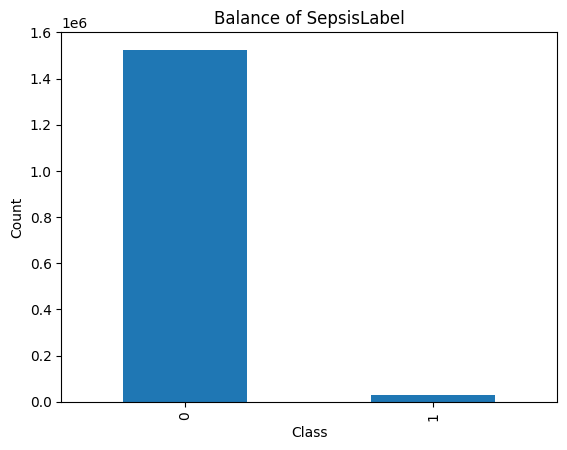

Label 0: 1524286 (83.33%)
Label 1: 304857 (16.67%)


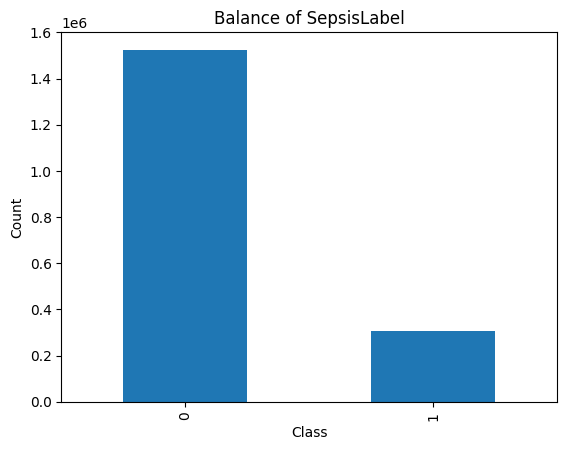

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from utils import get_data

# Load the dataset
DATA_PATH = get_data.get_dataset_abspath()
load_path = os.path.join(DATA_PATH, "imputed_sofa.parquet")
imputed_df = pd.read_parquet(load_path)

# 1. Print percentage of positive sepsis
sepsis_percentage = imputed_df['SepsisLabel'].mean() * 100
print(f"Percentage of positive sepsis: {sepsis_percentage:.2f}%")

# 2. For patients with sepsis, print SOFA level statistics
sepsis_sofa = imputed_df.loc[imputed_df['SepsisLabel'] == 1, 'SOFA']
print("SOFA score statistics for sepsis patients:")
print(sepsis_sofa.describe())

# 3. Function to print and graph dataset balance
def balance_report(df, target_column):
    counts = df[target_column].value_counts()
    total = counts.sum()
    for label, count in counts.items():
        print(f"Label {label}: {count} ({(count/total*100):.2f}%)")
    counts.plot(kind="bar", title=f"Balance of {target_column}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

# Example usage:
balance_report(imputed_df, 'SepsisLabel')

# 4. Function to balance the dataset (oversample or undersample)
def balance_dataset(df, target_column, method="oversample", minority_ratio=0.2):
    """
    sampling technique: oversampling increases the number of minority class samples, 
    while undersampling reduces the number of majority class samples

    what it does: adjusts class distribution by either duplicating 
    minority samples (oversampling) or removing majority samples (undersampling) 
    to improve model learning balance
    """
    counts = df[target_column].value_counts()
    majority_class = counts.idxmax()
    minority_class = counts.idxmin()
    df_majority = df[df[target_column] == majority_class]
    df_minority = df[df[target_column] == minority_class]

    if method == "oversample":
        n_samples = int(len(df_majority) * minority_ratio)
        df_minority_upsampled = resample(df_minority, replace=True, n_samples=n_samples, random_state=42)
        df_balanced = pd.concat([df_majority, df_minority_upsampled])
    elif method == "undersample":
        n_samples = int(len(df_minority) / minority_ratio) 
        df_majority_downsampled = resample(df_majority, replace=False, n_samples=n_samples, random_state=42)
        df_balanced = pd.concat([df_majority_downsampled, df_minority])
    else:
        raise ValueError("Method must be 'oversample' or 'undersample'")

    return df_balanced

# Example usage:
balanced_df = balance_dataset(imputed_df, 'SepsisLabel', method="oversample")
balance_report(balanced_df, 'SepsisLabel')



In [4]:
balanced_df = balance_dataset(imputed_df, 'SepsisLabel', method="undersample")
print("Total records in balanced dataset:", balanced_df.shape[0])
print(balanced_df['SepsisLabel'].value_counts())

Total records in balanced dataset: 167496
SepsisLabel
0    139580
1     27916
Name: count, dtype: int64


In [5]:
balanced_df.to_parquet(f"{project_root}/dataset/balanced_dataset.parquet", index=False)
print("Balanced dataset saved with", balanced_df.shape[0], "records.")

Balanced dataset saved with 167496 records.
